# Music Valence Prediction: Tensorflow Keras

***

## Project Description

### The Objective

The goal of this task is to develop a Python-based module to predict the valence of newly released pop songs.   Two approaches are to use as an input: 
1) the audio data (e.g. `.wav` files) 
2) the songs lyrics

Publicly available datasets can be used for training and testing. 

### Audio Signal Features
<a id="audio-features"></a>

In this version of the project, the approach of the following research paper will be implemented: [Measuring national mood with music](https://link.springer.com/article/10.3758/s13428-021-01747-7). Specifically, the same [set of features](https://static-content.springer.com/esm/art%3A10.3758%2Fs13428-021-01747-7/MediaObjects/13428_2021_1747_MOESM1_ESM.pdf) will be tried to extract. These features are:
- [x] Spectral Centroid;
- [x] Spectral Rolloff;
- [x] Spectral Contrast — ~~7 bands~~ *(kept the default 6 bands instead)*;
- [x] Mel-Frequency Cepstrum Coefficients (MFCC) — 24 coefficients;
- [x] Zero Crossing Rate;
- [x] Chroma Energy Normalized Statistics (CENS) — 12 chroma;
- [x] Beat Per Minute (BPM);
- [x] Root Mean Square (RMS);
- [ ] ~~Spectral Flux~~*(couldn't extract)*;
- [ ] ~~Onset Rate~~(couldn't extract);
- [ ] ~~High Frequency Content (HFC)~~ *(couldn't extract, seemingly the same as Spectral Rolooff with high frequency)*;

### The Dataset

Fr this task, the more recent version of this dataset will be used: [DEAM dataset](https://cvml.unige.ch/databases/DEAM/). It seemingly has a more diverse range of music genres, including electronic and Hip-hop music, which are absent in the previous version.

***

## Imports and Config

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import librosa
import librosa.display
import IPython.display as ipd

from scipy import stats as st
from scipy.signal import get_window

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import os
import re
from tqdm import tqdm
from time import time
from datetime import date

from sklearn.model_selection import train_test_split

In [2]:
# set up some parameters for plots in this notebook
plt.style.use("seaborn-v0_8-paper")
sns.set_style("dark", {"axes.facecolor": ".95"})
sns.set_palette("mako")
sns.set_context("notebook")

plt.rcParams["figure.figsize"] = (10, 4)
%config InlineBackend.figure_format = "retina"

In [3]:
# save random state number in advance
seed = 12345

***

## Data Preprocessing

### Annotations data

In [4]:
# read the annotations file
annot = pd.read_csv("datasets/static_annotations_averaged_songs_1_2000.csv")

In [5]:
# show general info
annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.2 KB


In [6]:
# print several random rows
annot.sample(3)

,song_id,valence_mean,valence_std,arousal_mean,arousal_std
354,426,5.3,1.68,5.3,1.42
1199,1456,4.3,1.62,2.2,0.75
156,188,4.0,1.55,3.3,1.55


The column names contain "mean" and "std" due to the labeling procedure: each song was labeled by 10 people. The average value of all rates was then taken and the standard deviation was calculated. For this project, this information is not needed.

In [7]:
# the column names contain empty spaces, fix that
annot.columns = [col.replace(" ","") for col in annot.columns]

In [8]:
# drop extra columns
annot.drop(columns=["valence_std","arousal_std"], inplace=True)
# shortent the column names
annot.rename(columns={"valence_mean":"valence", "arousal_mean":"arousal"}, inplace=True)
annot.sample(3)

,song_id,valence,arousal
1047,1304,5.2,6.3
354,426,5.3,5.3
1594,1851,4.6,3.3


### Metadata

In [9]:
# read the meatdata file
meta = pd.read_csv("datasets/metadata_1_2000.csv")

In [10]:
# show general info
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   song_id                         1744 non-null   int64  
 1   file_name                       744 non-null    object 
 2   Artist                          1744 non-null   object 
 3   Song title                      1744 non-null   object 
 4   start of the segment (min.sec)  1744 non-null   float64
 5   end of the segment (min.sec)    1744 non-null   float64
 6   Genre                           1744 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 95.5+ KB


The reason the `file_name` column contains missing values is that this file was compiled from two (with the use of MS Excel) and the second of these files didn't have this information. However, the file names can be derived from the `song_id` column.

In [11]:
# print a sample of the meta set
meta.sample(3)

,song_id,file_name,Artist,Song title,start of the segment (min.sec),end of the segment (min.sec),Genre
1223,1480,NaN,The Shivers,Kisses,170.112540,253.558617,Folk-Rock
1408,1665,NaN,Lucas Perný a Miloslav Kollár,Astral Gate,220.268299,452.899025,International-Experimental-Rock
121,151,\t151.mp3,James Beaudreau\t,\tPacifico\t,0.590000,1.440000,\tClassical\t


The segment points are noted differently for the first 744 song, than it is for the second 100. However, it is known that each audio file in this dataset is 45 seconds length.

In [12]:
# tidy up the column names
meta.columns = ["song_id","file_name","artist","song_title","segment_start","segment_end", "genre"]
# fill in missing song titles
meta["song_title"].fillna("unknown", inplace=True)

In [13]:
# remove artifacts
for col in ["artist","song_title","genre"]:
    meta[col] = [re.sub(r"\t", "", string) for string in meta[col]]

# constract new file_name column
meta["file_name"] = meta["song_id"].astype(str) + ".mp3"

# print sample to check
meta.sample(3)

,song_id,file_name,artist,song_title,segment_start,segment_end,genre
1340,1597,1597.mp3,Fanatic,Dream,104.266168,224.275351,Hip-Hop
1206,1463,1463.mp3,Spires That in the Sunset Rise,Clouds,76.073855,386.417392,Folk
677,892,892.mp3,Paneye,North Sea Radio,0.580000,1.430000,Rock


### Merge datasets

In [14]:
data = annot.merge(meta, on="song_id",how="outer")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 1743
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1   valence        1744 non-null   float64
 2   arousal        1744 non-null   float64
 3   file_name      1744 non-null   object 
 4   artist         1744 non-null   object 
 5   song_title     1744 non-null   object 
 6   segment_start  1744 non-null   float64
 7   segment_end    1744 non-null   float64
 8   genre          1744 non-null   object 
dtypes: float64(4), int64(1), object(4)
memory usage: 136.2+ KB


***

## EDA

### Valence vs arousal

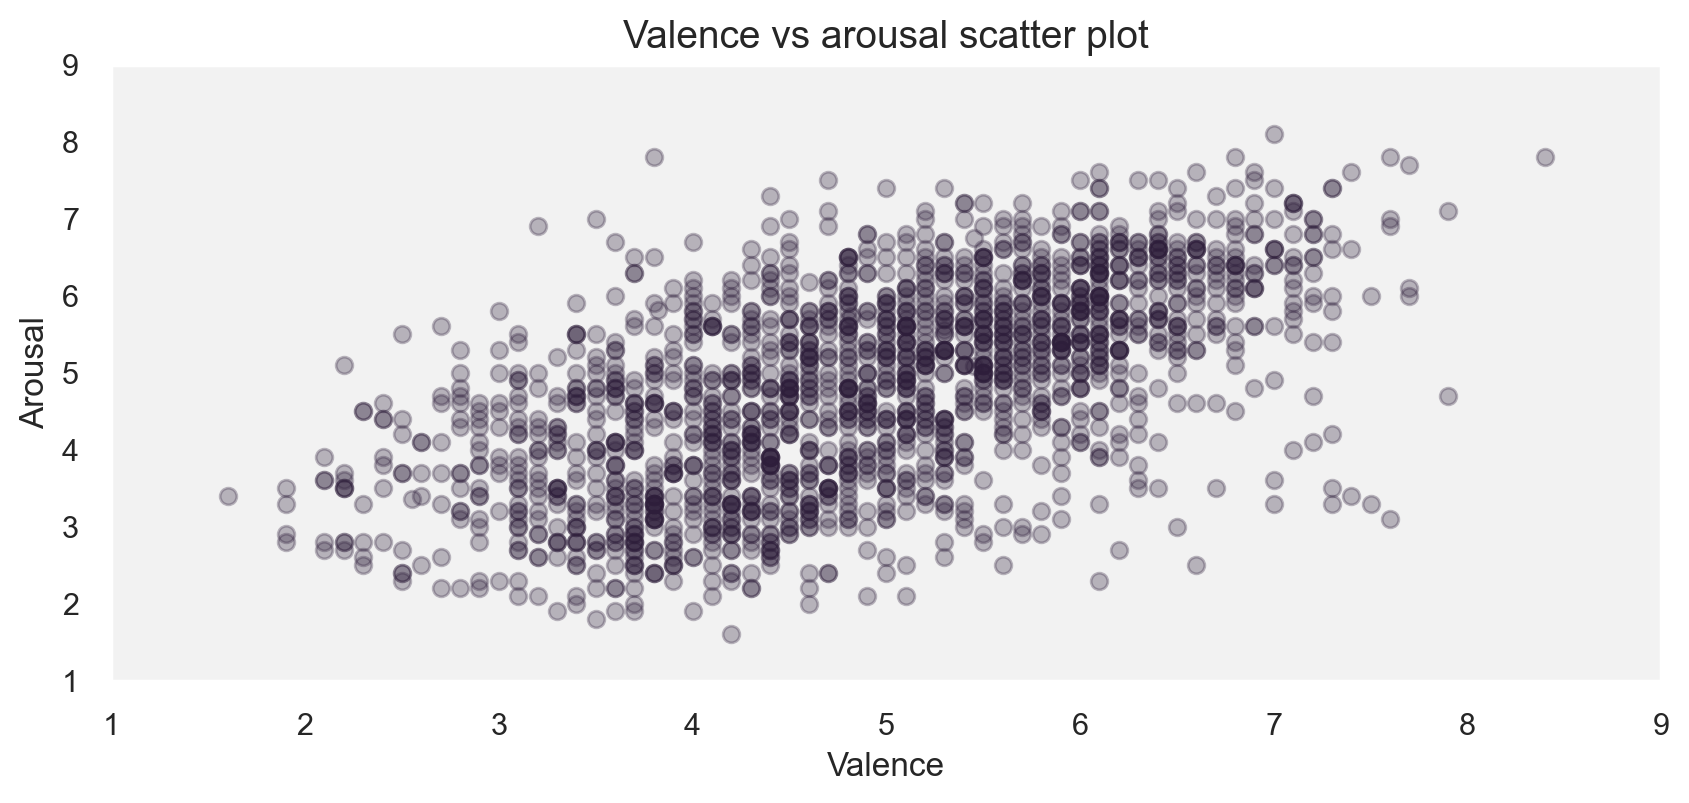

In [15]:
# plot the valence and arousal values distribution
plt.scatter(data["valence"], data["arousal"], alpha=.3)
plt.title("Valence vs arousal scatter plot", fontsize=14)
plt.xlim([1,9])
plt.ylim([1,9])
plt.xlabel("Valence")
plt.ylabel("Arousal");

There is a noticeable general correlation between these values, which is expected.

### Genre classes balance

Unique genres in the dataset:  126



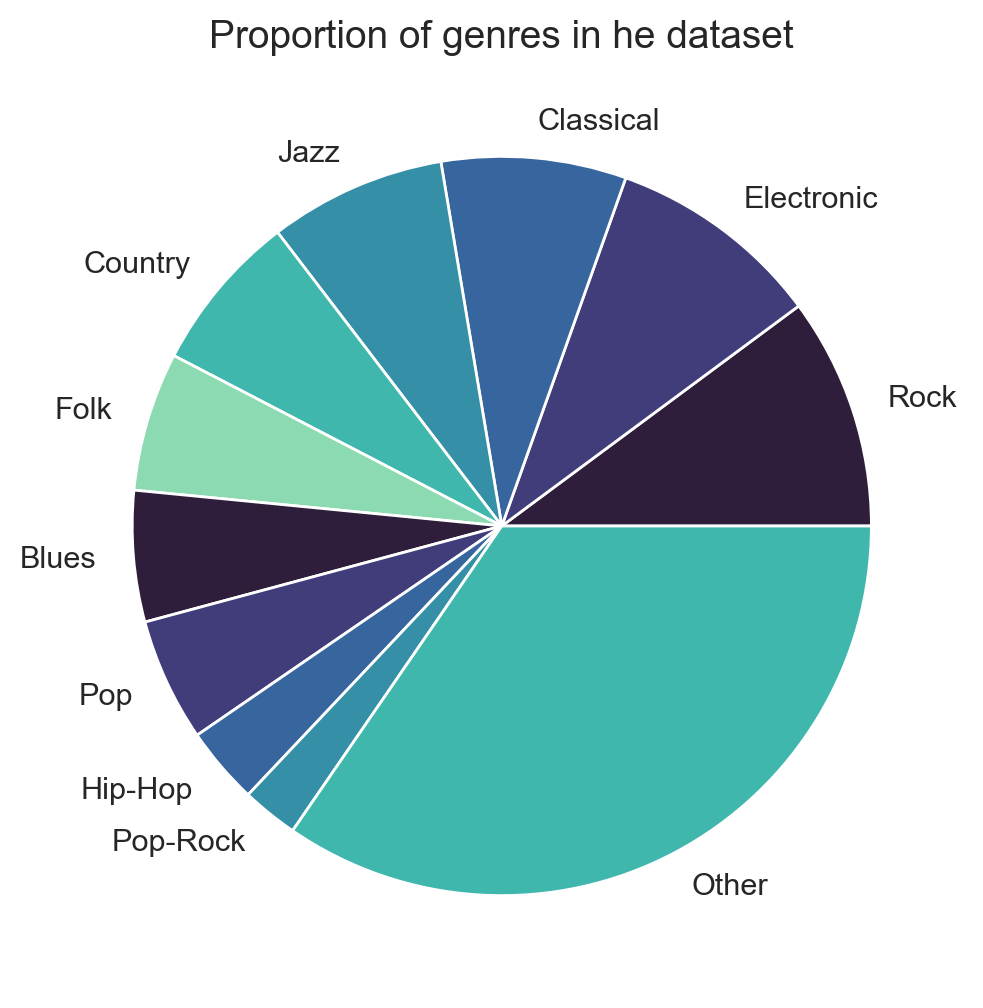

In [16]:
# count the number of genres present in the dataset
nunique_genres = data["genre"].nunique()
print("Unique genres in the dataset:  {}\n".format(nunique_genres))

# select the top 10
top10_genres = data["genre"].value_counts()[:10]
top10_genres.loc["Other"] = data["genre"].value_counts()[10:].sum()

# plot a pie chart with genres ratio
plt.figure(figsize=(6,6))
labels = top10_genres.index
plt.pie(top10_genres, labels=labels)
plt.title("Proportion of genres in he dataset", fontsize=14);

The data contains a variety of music genres. Among the top-10 are present some genres related to this task: Pop, Hip-Hop, Rock, Pop-Rock, and Electronic.

### Audio and waveform

/Users/ioann/Applications/miniconda3/envs/tensorflow/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Sampling rate: 22050
song_id                   1404
valence                    3.8
arousal                    2.7
file_name             1404.mp3
artist           Art of Flying
song_title               sleep
segment_start         4.694694
segment_end          58.373333
genre                Folk-Rock
Name: 1147, dtype: object


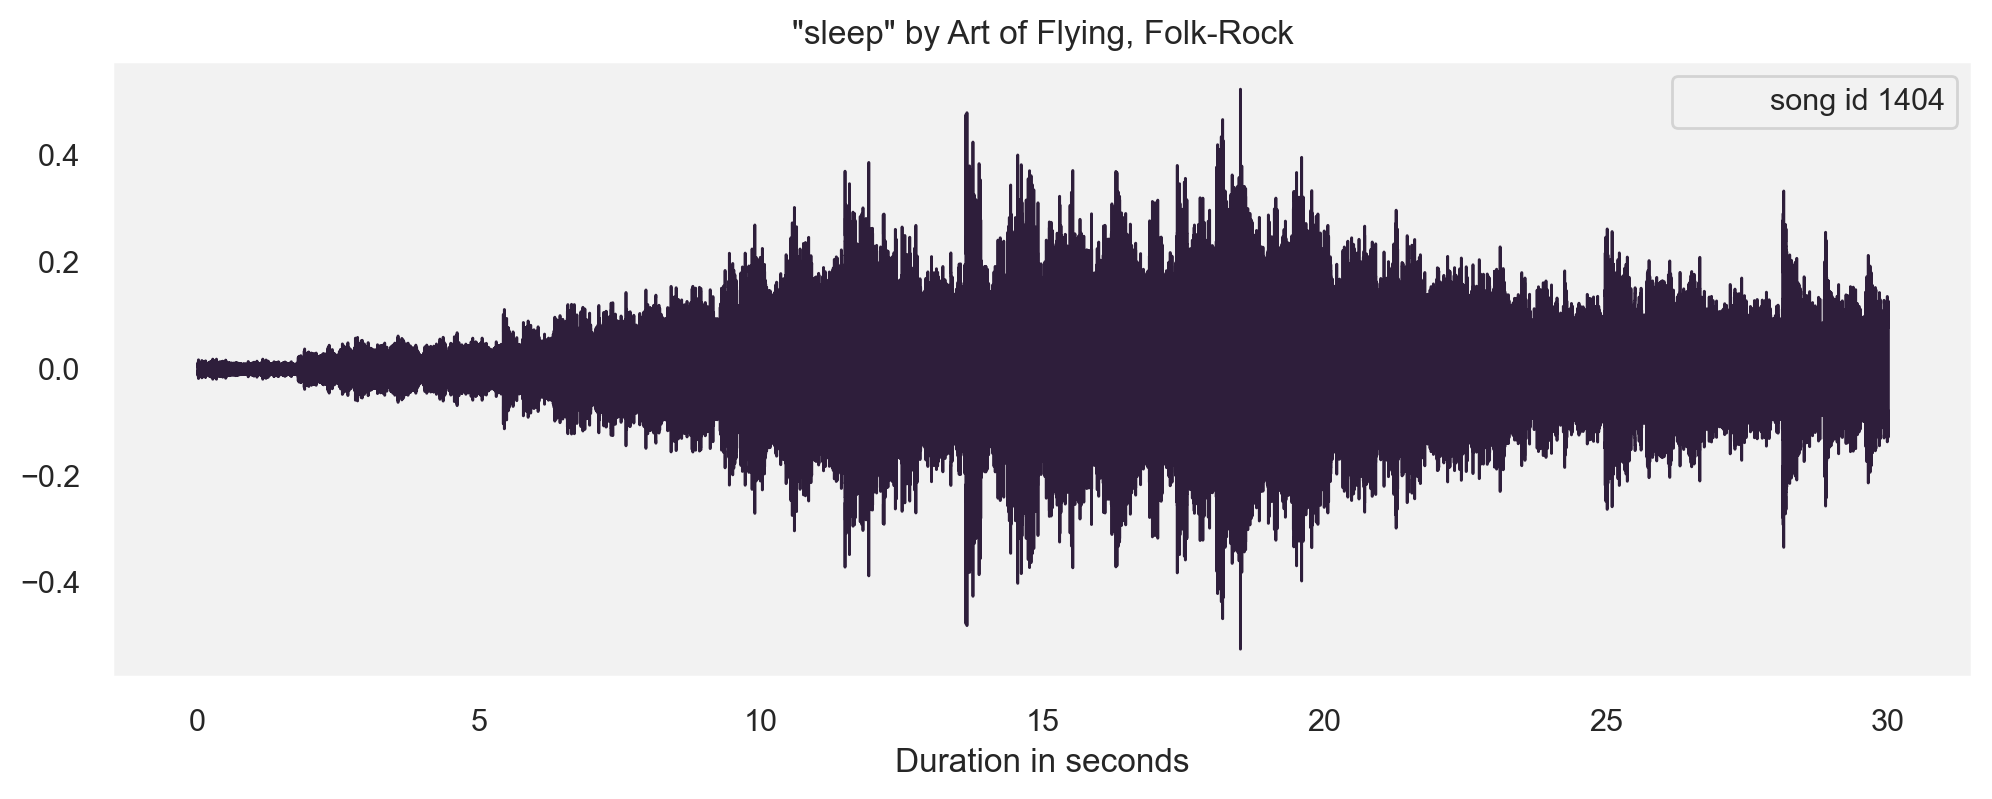

In [17]:
random_idx = np.random.randint(0, 1744)

# select a random song from the dataset
song = data.loc[random_idx, :]

# load the file and print its sampling rate 
file_path = "datasets/audio_files/" + song["file_name"]
y, sr = librosa.load(file_path, duration=30) # select only 30 seconds
# print info about this song
print(f"Sampling rate: {sr}")
print(song)

# plot the wavefrom
plt.figure(figsize=(12,4))
librosa.display.waveshow(y, sr=sr) # plot a waveform and play the file
plt.title(f'"{song.song_title[:15]}" by {song.artist}, {song.genre}')
plt.legend([f"song id {song.song_id}"])
plt.xlabel("Duration in seconds")

# output the audio
ipd.Audio(file_path)

Some songs don't sound like they belong to the genre with which they were associated. For example, [song 402](https://freemusicarchive.org/music/Patrick_Lee/Bad_Panda_42/Quittin_Time/) is way more funk than electronic, but it was marked as Electronic in the dataset, and [song 43](https://freemusicarchive.org/music/The_Agrarians/Uncomfortably_Songwriter_Vol_VI/Puritans_Too_1938/) can barely be described as Blues.

***

## Audio Features

Look at some of the audio features available with `librosa` and build a features extraction procedure. The feature descriptions are mostly taken from [this text](https://blog.paperspace.com/music-genre-classification-using-librosa-and-pytorch/https://blog.paperspace.com/music-genre-classification-using-librosa-and-pytorch/).

### Mel Frequency Cepstral Coefficients (MFCC)

MFCCs are Cepstral coefficients calculated by a discrete cosine transform applied to the power spectrum of a signal. The frequency bands of this spectrum are spaced logarithmically according to the Mel scale.

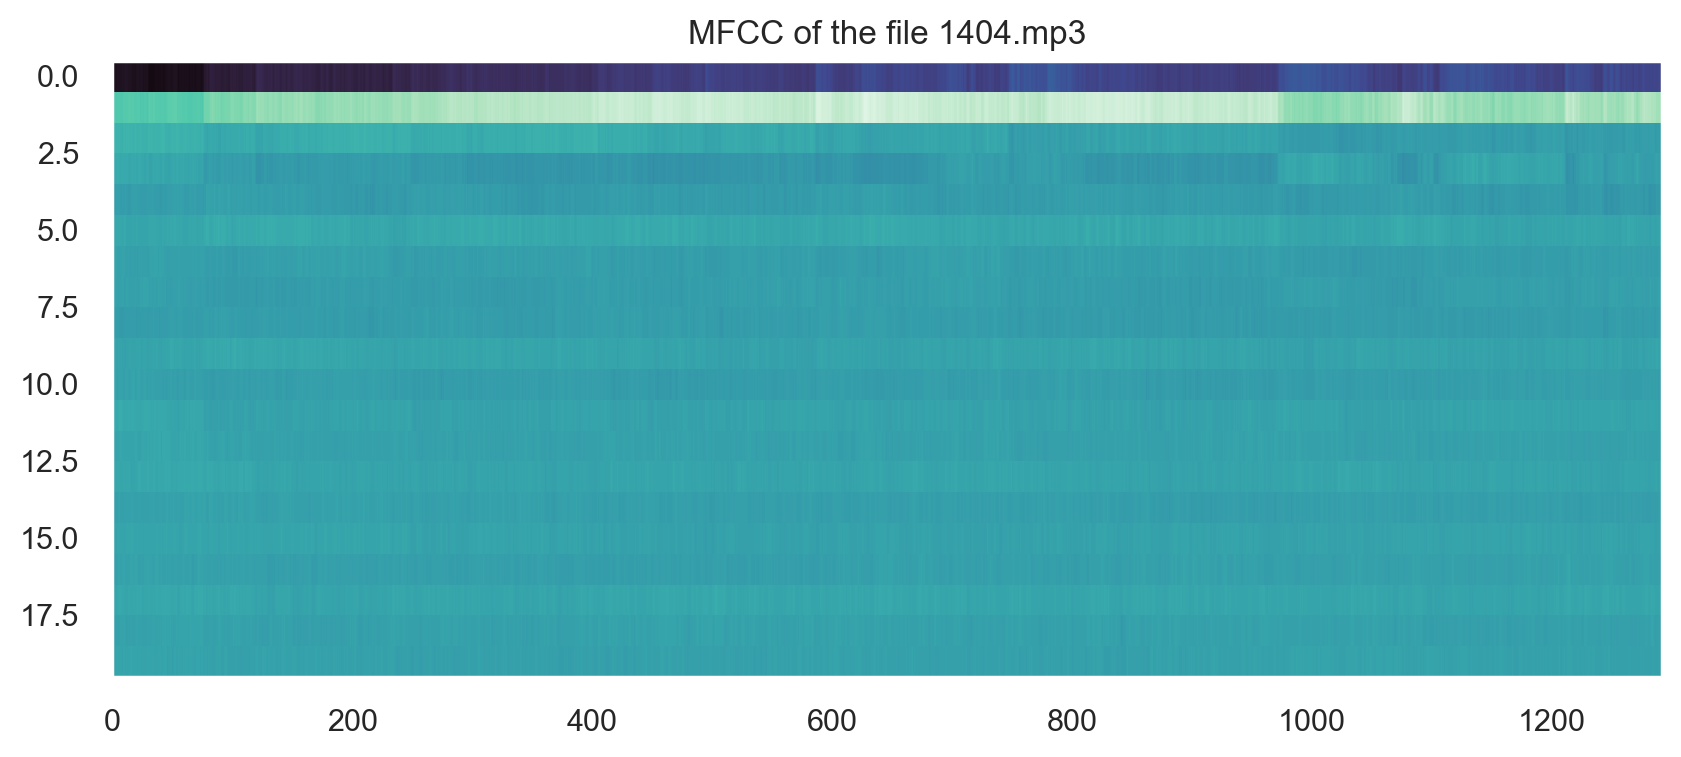

In [18]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
plt.imshow(mfcc, interpolation="nearest", aspect="auto", cmap="mako")
plt.title("MFCC of the file {}".format(song.file_name));

### Mel Spectrogram

The Mel spectrogram is the standard spectrogram in the Mel scale, which is a perceptual scale of pitches that listeners perceive to be equally spaced from one another. The conversion from the frequency in hertz to the Mel scale is done using the following formula:
$$
m = 2595\ \text{log}_{10}(1 + \frac{f}{700})
$$

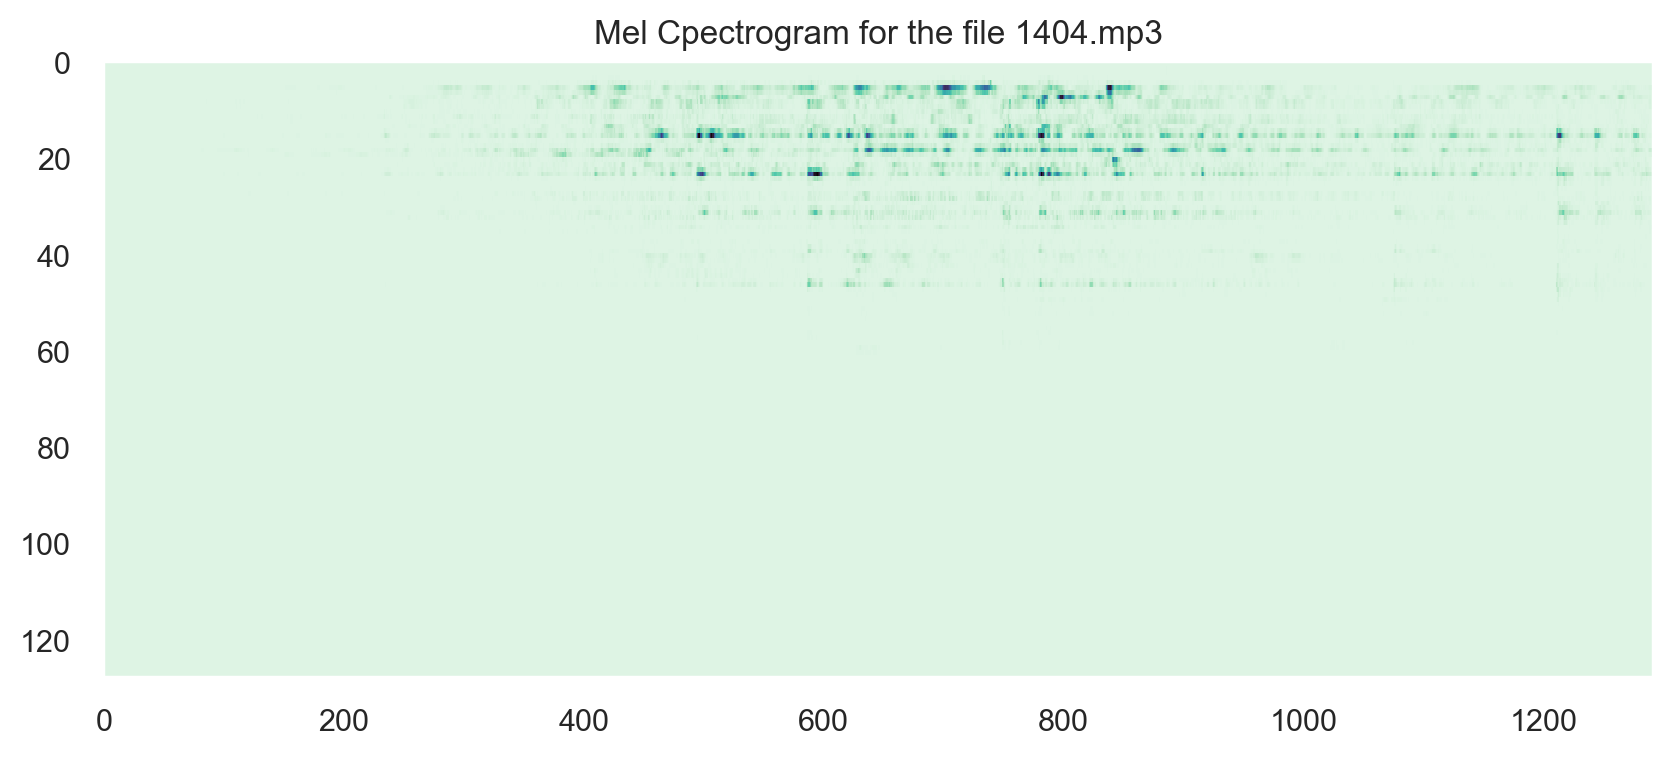

In [19]:
melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)        # reverse cmap for better visability 
plt.imshow(melspectrogram, interpolation="nearest", aspect="auto", cmap=matplotlib.cm.get_cmap("mako_r"))
plt.title("Mel Cpectrogram for the file {}".format(song.file_name));

### Chroma Vector

The Chroma features vector is constructed by having the full spectrum projected onto 12 bins that reflect the 12 unique semitones (or Chroma) of the musical octave: **C, C#, D, D#, E, F, F#, G, G#, A, A#, B**. This projection gives an intriguing and potent representation of music audio and is especially dependent on the music genre.  

Since notes that are exactly one octave apart are perceived as being particularly similar in music, understanding the distribution of Chroma, even without knowing the absolute frequency (i.e., the original), can provide useful musical information about the audio and may even expose perceived musical similarities in the same music genre that are not visible in the original spectra.

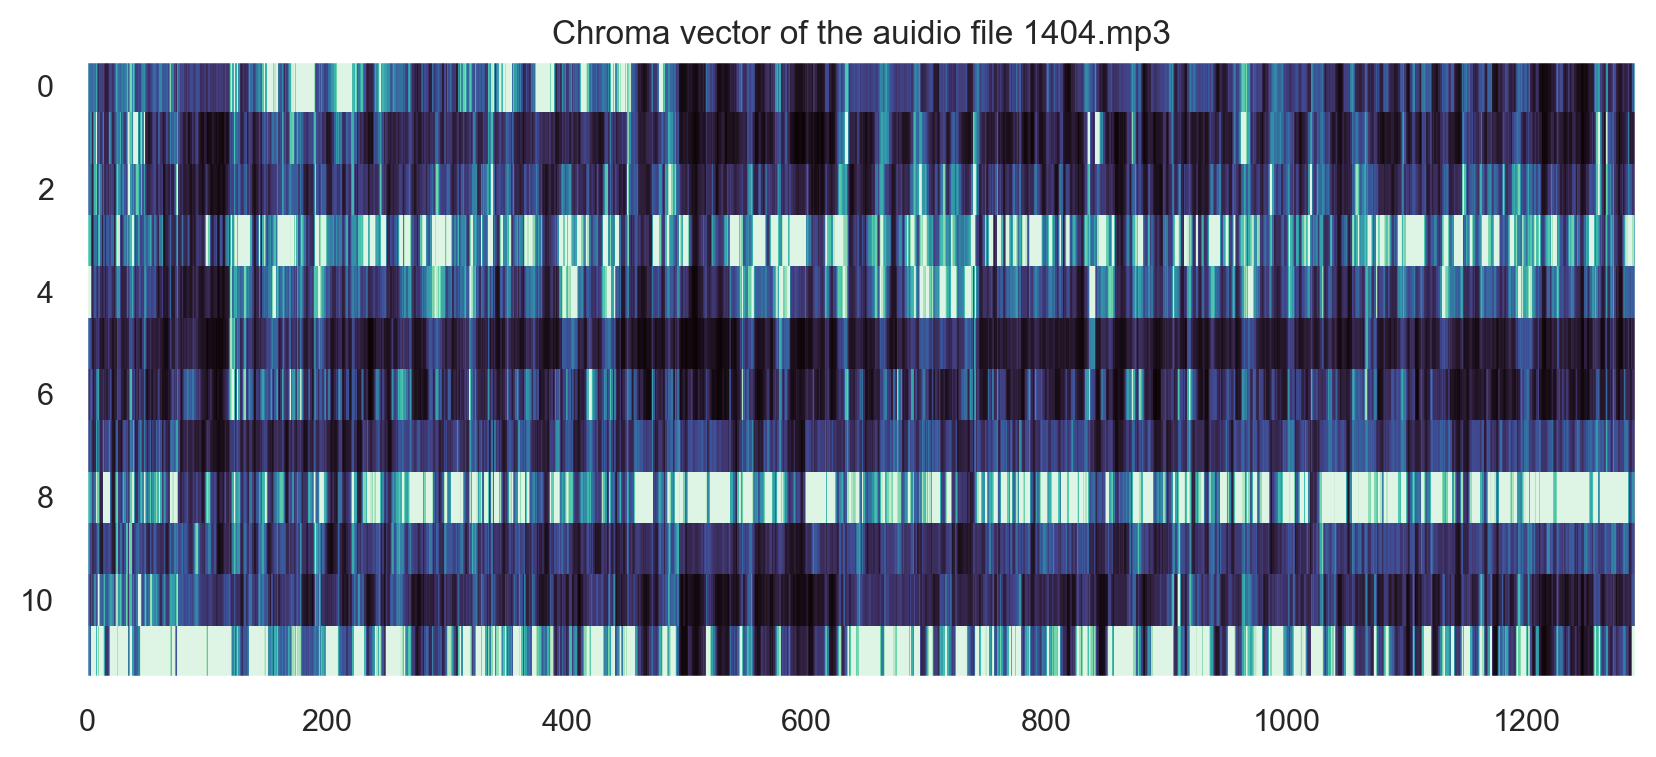

In [20]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.imshow(chroma,interpolation="nearest", aspect="auto", cmap="mako")
plt.title("Chroma vector of the auidio file {}".format(song.file_name));

### Tonal Centroid Features (Tonnetz)

Tonnetz is calculated by projecting Chroma features onto a 6-dimensional basis representing the perfect fifth, minor third, and major third each as two dimensional coordinates.

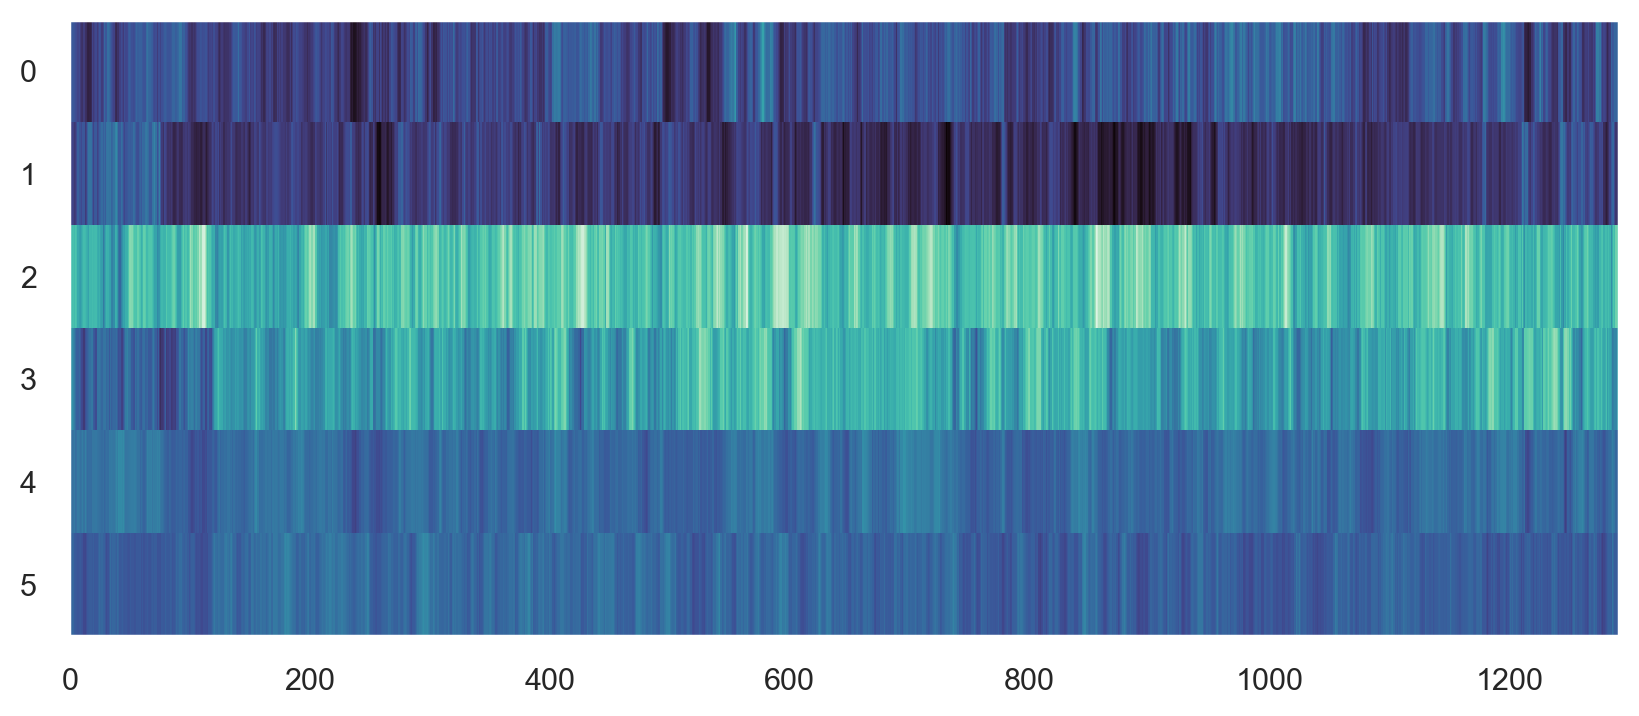

In [21]:
tntz = librosa.feature.tonnetz(y=y, sr=sr)
plt.imshow(tntz, interpolation="nearest", aspect="auto", cmap="mako");

***

## Features preparation

### Extraction procedure

In [22]:
def extract_features(file_path):
    
    y, sr = librosa.load(file_path, duration=30) # select only 30 seconds 
    
    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_var = mfcc.var(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_var, mfcc_min, mfcc_max))
    
    # Mel Spectrogram
    melspec = librosa.feature.melspectrogram(y=y, sr=sr)
    melspec_mean = melspec.mean(axis=1)
    melspec_var = melspec.var(axis=1)
    melspec_min = melspec.min(axis=1)
    melspec_max = melspec.max(axis=1)
    melspec_feature = np.concatenate(
        (melspec_mean, mfcc_var, mfcc_min, mfcc_max)
    )
    
    # Chroma vector
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = chroma.mean(axis=1)
    chroma_var = chroma.var(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate(
        (chroma_mean, chroma_var, chroma_min, chroma_max)
    )
    
    # Tonnetz
    tntz = librosa.feature.tonnetz(y=y, sr=sr)
    tntz_mean = tntz.mean(axis=1)
    tntz_var = tntz.var(axis=1)
    tntz_min = tntz.min(axis=1)
    tntz_max = tntz.max(axis=1)
    tntz_feature = np.concatenate(
        (tntz_mean, tntz_var, tntz_min, tntz_max)
    )
    
    features = np.concatenate(
        (mfcc_feature, melspec_feature, chroma_feature, tntz_feature)
    )
    return features

### Extract features

In [23]:
# features_df = []
# for i in tqdm(range(len(data))):
    
#     file_name = data.loc[i, "file_name"]
#     file_path = "datasets/audio_files/" + file_name
#     features_df.append(extract_features(file_path))

In [24]:
# features_df = pd.DataFrame(features_df)

In [25]:
# features_df.to_csv("features_df_2022-12-26.csv")

In [26]:
features_df = pd.read_csv("datasets/features_df_2022-12-26.csv", index_col=0)

### Split the data

In [27]:
X = features_df.values
y = data.valence.values

X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=.25, random_state=seed)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1046, 340)
(349, 340)
(349, 340)


***

## Model training

In [37]:
# build the model
model = Sequential()
optimizer = Adam(learning_rate=0.01)

# the first layer
model.add(Dense(300, input_dim=340, activation="relu"))
model.add(Dropout(.1))
# the second layer
# the third layer
model.add(Dense(200, activation="relu"))
# the final layer
model.add(Dense(1))

model.compile(
    loss="mean_squared_error", 
    metrics=["mean_absolute_error"], 
    optimizer=optimizer
)

In [39]:
# train the model
num_epochs = 200
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath="saved_models/valence_predicition.hdf5",
                              verbose=1, save_best_only=True)

# initialize callbacks
earlystop = EarlyStopping(patience=20)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_mean_absolute_error", 
                                                patience=10, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)

# fit the model
model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=num_batch_size,
    epochs=num_epochs,
    callbacks=[checkpointer, earlystop, learning_rate_reduction],
    verbose=1
)

Epoch 1/200
27/33 [=======================>......] - ETA: 0s - loss: 1.6703 - mean_absolute_error: 1.0113
Epoch 1: val_loss improved from inf to 1.82916, saving model to saved_models/valence_predicition.hdf5
33/33 [==============================] - 0s 9ms/step - loss: 1.6132 - mean_absolute_error: 0.9913 - val_loss: 1.8292 - val_mean_absolute_error: 1.0505 - lr: 0.0025
Epoch 2/200
28/33 [========================>.....] - ETA: 0s - loss: 1.4413 - mean_absolute_error: 0.9190
Epoch 2: val_loss improved from 1.82916 to 1.76172, saving model to saved_models/valence_predicition.hdf5
33/33 [==============================] - 0s 8ms/step - loss: 1.4041 - mean_absolute_error: 0.9079 - val_loss: 1.7617 - val_mean_absolute_error: 1.0424 - lr: 0.0025
Epoch 3/200
28/33 [========================>.....] - ETA: 0s - loss: 1.2481 - mean_absolute_error: 0.8851
Epoch 3: val_loss improved from 1.76172 to 1.11221, saving model to saved_models/valence_predicition.hdf5
33/33 [==============================] -